# Import библиотек

In [1]:
import os
from pathlib import Path
import sys
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import bootstrap

# Набор данных


Набор данных для ранжирования предварительно отобранных товаров на основе локации клиента, рекламы, конверсии и т.д. Необходимо разработать модель которая будет оптимально ранжировать полученные данные<br>
Оценка решения производится на основании качества модели на отложенной по времени выборке. <br>
На данном этапе вам необходимо: <br>
•	Проработать проблематику (чем подобного рода проблемы могут грозить бизнесу) <br>
•	Грамотно формализовать задачу <br>
•	Проанализировать имеющиеся данные и оценить их пригодность для решения поставленной задачи <br>
•	Провести первичный разведочный анализ данных (EDA)

1. Проблематика <br>

1.1 Если в модели не будут учтены важные факторы для пользователя (Например, если у пользователя есть предпочтения по бренду или типу товара, но эти факторы не учитываются при ранжировании, это может привести к неправильному порядку отображения товаров) <br>
1.2 Смещённость или предвзятость. В данных могут быть смещение (позиционное, социальное или смещение из-за взаимодействия) <br>
   Социальное связано с работой с разными группами людей <br>
   Смещение из-за взаимодействия за счёт специфики пользовательского интерфейса <br>
   Позиционное смещение  связано с тем где в выдаче будет находиться товар<br>
   Также может быть смещение связанное с сезонностью покупок  <br>
1.3 Сложность интерпретации <br>
   Некоторые модели могут быть сложными для интерпретации <br>
   Это может затруднить понимание того, почему определенный товар был выбран для рекомендации, что может вызвать недовольство у клиентов <br>
1.4 Обучение на устаревших данных  <br>
   Если модель обучается на устаревших данных или данные быстро меняются, то она может перестать быть актуальной и перестать точно ранжировать товары.
   Это особенно критично для товаров, чья популярность или предпочтения клиентов изменяются во времени.

In [32]:
df_train = pl.read_parquet("C:\\Users\\User\\Downloads\\train_features.parquet")
df_test = pl.read_parquet("C:\\Users\\User\\Downloads\\test_features.parquet")

In [3]:
df_train.head(5)

query_id,report_date,target,rn,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
u32,datetime[ns],bool,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,2024-01-11 00:00:00,false,4,0.693,0.1,0.245833,3.376496,0.7777,0.0,2.87166,0.97,1.0,4.6,-0.196707
2,2024-01-11 00:00:00,false,5,0.281,0.1,0.108333,2.909165,0.7882,0.0,1.978092,0.96,0.89,4.8,0.034091
2,2024-01-11 00:00:00,false,8,0.319,0.183333,0.154167,1.725731,0.688,0.5,2.083885,0.95,0.9,4.7,0.286658
2,2024-01-11 00:00:00,false,10,0.281,0.1,0.108333,3.759698,0.7882,1.0,1.898608,0.98,0.81,4.8,0.052632
2,2024-01-11 00:00:00,false,12,0.281,0.1,0.108333,0.026253,0.7055,0.0,0.317658,0.96,0.85,4.7,0.172424



query_id - это уникальный айдишник пользоательской сессии по запросу <br>
таргет - был ли совершён заказ <br>
rn - ranking number <br>
report_date - дата запроса <br>
feature_1-11 - обфусцированные фичи

In [5]:
df_train.shape

(22691379, 15)

Посмотрим на пропуски

In [6]:
df_train.null_count()

query_id,report_date,target,rn,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,3266,0,0,7605609,0,0,0


Очень много пропусков в feature_8, гораздо меньше в feature_5 в остальных нет.

In [9]:
df_test.shape

(1733865, 15)

In [10]:
df_test.null_count()

query_id,report_date,target,rn,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,925,0,0,596019,0,0,0


В тестовой та же ситуация

In [7]:
df_train['rn'].n_unique()

100

In [14]:
df_test['rn'].n_unique()

100

Количество rn ограничено 100, видимо дальше вообше не покупают или покупают совсем мало

In [8]:
df_train['query_id'].n_unique()

265137

Количество уникальных query_id сильно меньше общего числа запросов, что логично. Люди открывают много товаров, от этого много запросов

In [15]:
df_train.describe()

statistic,query_id,report_date,target,rn,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.2691379e7,"""22691379""",2.2691379e7,2.2691379e7,2.2691379e7,2.2691379e7,2.2691379e7,2.2691379e7,2.2688113e7,2.2691379e7,2.2691379e7,1.508577e7,2.2691379e7,2.2691379e7,2.2691379e7
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,3266.0,0.0,0.0,7.605609e6,0.0,0.0,0.0
"""mean""",298297.604273,"""2024-01-18 11:…",0.012747,53.102646,0.730732,0.219791,0.296802,0.615299,0.803091,0.103176,1.345817,0.940945,0.717853,4.66981,0.075862
"""std""",172791.460958,null,null,28.062587,0.922102,0.242939,0.246257,1.326826,0.108361,0.298695,1.515479,0.048151,0.181307,0.151729,0.144936
"""min""",2.0,"""2024-01-11 00:…",0.0,1.0,0.0,0.016667,0.0,0.0,0.0001,-1.0,0.0,0.23,0.01,3.2,-3.0
"""25%""",149060.0,"""2024-01-15 00:…",null,29.0,0.134,0.1,0.133333,0.00885,0.75,0.0,0.0,0.92,0.67,4.6,0.025382
"""50%""",298123.0,"""2024-01-18 00:…",null,54.0,0.398,0.116667,0.2125,0.095728,0.82,0.0,0.892091,0.95,0.75,4.7,0.086021
"""75%""",447982.0,"""2024-01-22 00:…",null,77.0,0.9235,0.25,0.375,0.521567,0.87,0.0,2.295441,0.97,0.83,4.8,0.14796
"""max""",598221.0,"""2024-01-25 00:…",1.0,100.0,9.7845,8.4,5.245833,9.999986,1.0,1.0,16.146496,1.0,1.0,5.0,0.998144


In [42]:
df_train["report_date"]

report_date
datetime[ns]
2024-01-11 00:00:00
2024-01-11 00:00:00
2024-01-11 00:00:00
2024-01-11 00:00:00
2024-01-11 00:00:00
…
2024-01-25 00:00:00
2024-01-25 00:00:00
2024-01-25 00:00:00


Видим, что для анализа есть только дни. Часы везде 00.00.00

Посмотрим на пользователей с наибольшим количеством заказов

In [16]:
df_train.group_by(['report_date', 'query_id']).agg(pl.col("target").sum()).sort('target') 

report_date,query_id,target
datetime[ns],u32,u32
2024-01-23 00:00:00,350230,1
2024-01-24 00:00:00,65699,1
2024-01-20 00:00:00,475745,1
2024-01-16 00:00:00,230828,1
2024-01-12 00:00:00,385209,1
…,…,…
2024-01-15 00:00:00,241060,10
2024-01-17 00:00:00,368001,11
2024-01-25 00:00:00,36269,11


Посмотрим на покупателей с наибольшим количеством заказов

In [21]:
# Загрузка данных в Pandas DataFrame
df_train = pd.read_parquet('C:\\Users\\User\\Downloads\\train_features.parquet')

# Группировка данных по query_id и подсчет числа значений true в target для каждого запроса
true_count_by_query = df_train[df_train['target']].groupby('query_id').size().reset_index(name='true_count')

# Находим запрос с наибольшим количеством значений true
max_true_query = true_count_by_query.sort_values(by='true_count', ascending=False).head(1)

# Выводим результат
print("Запрос с наибольшим количеством значений true:")
print(max_true_query)




Запрос с наибольшим количеством значений true:
        query_id  true_count
259743    585938          19


In [22]:
# Группировка данных по query_id и подсчет числа значений true в target для каждого запроса
true_count_by_query = df_train[df_train['target']].groupby('query_id').size().reset_index(name='true_count')

# Находим топ 10 запросов с наибольшим количеством значений true
top_10_queries = true_count_by_query.sort_values(by='true_count', ascending=False).head(10)

# Выводим результат
print("Топ 10 запросов с наибольшим количеством значений true:")
print(top_10_queries)

Топ 10 запросов с наибольшим количеством значений true:
        query_id  true_count
259743    585938          19
11029      23098          15
16460      36269          11
163373    368001          11
194094    437207          10
202593    456246          10
202578    456206          10
228779    515598          10
187002    421177          10
106983    241060          10


Количества покупок впринцпипе адекватное, каких-то уникумов, скупающих весь WB нет

Посмотрим на количество false для пользователей с наибольшим количеством покупок

In [24]:
# Фильтрация данных для query_id=585938 и подсчет количества значений false
false_count_query_585938 = df_train[(df_train['query_id'] == 585938) & (~df_train['target'])].shape[0]

# Выводим результат
print("Количество значений false для query_id=585938:", false_count_query_585938)


Количество значений false для query_id=585938: 63


In [25]:
# Фильтрация данных для query_id=585938 и подсчет количества значений false
false_count_query_23098 = df_train[(df_train['query_id'] == 23098) & (~df_train['target'])].shape[0]

# Выводим результат
print("Количество значений false для query_id=23098:", false_count_query_23098)

Количество значений false для query_id=23098: 77


Тоже адекватные значения

Посмотрим ещё на пользователей с каунтером false

In [28]:
# Группировка данных по query_id и подсчет числа значений false в target для каждого запроса
false_count_by_query = df_train[~df_train['target']].groupby('query_id').size().reset_index(name='false_count')

# Находим топ 10 запросов с наибольшим количеством значений false
top_100000_false_queries = false_count_by_query.sort_values(by='false_count', ascending=False).head(100000)

# Выводим результат
print("Топ 100000 запросов с наибольшим количеством значений false:")
print(top_100000_false_queries)


Топ 100000 запросов с наибольшим количеством значений false:
        query_id  false_count
253620    571950           99
52145     117284           99
52152     117300           99
221307    498602           99
52158     117313           99
...          ...          ...
220286    496159           94
68204     153619           94
36205      81326           94
68199     153613           94
55924     125361           94

[100000 rows x 2 columns]


Странновато, что количество false для пользователей ограниченно 99, но ок

## Зависимости числа покупок от даты 

Посмотрим на количество true по датам

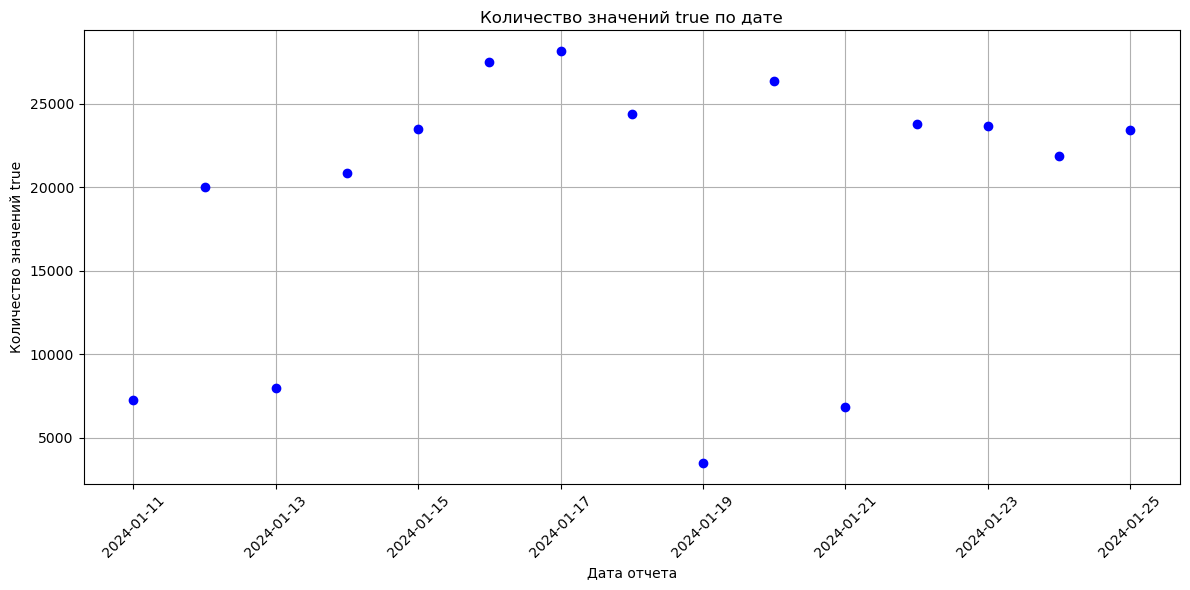

In [33]:
# Фильтрация данных, оставляя только записи с target=true
true_data = df_train.filter(df_train['target'])

# Группировка данных по report_date и подсчет числа записей (количество true) для каждой даты
grouped_true_data = true_data.group_by('report_date').agg(pl.count('target').alias('count_true'))

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(grouped_true_data['report_date'], grouped_true_data['count_true'], marker='o', linestyle='', color='blue')
plt.title('Количество значений true по дате')
plt.xlabel('Дата отчета')
plt.ylabel('Количество значений true')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
df_pandas = df_train.to_pandas()

# Фильтрация данных, оставляя только записи с report_date равным '2024-01-11 00:00:00' и target=true
count_true_on_date = df_pandas[(df_pandas['report_date'] == '2024-01-11 00:00:00') & (df_pandas['target'])].shape[0]

# Вывод результата
print("Количество значений true для report_date='2024-01-11 00:00:00':", count_true_on_date)

Количество значений true для report_date='2024-01-11 00:00:00': 7242


Теперь сравним этот график с графиком уникальных query_id от даты

<Axes: xlabel='report_date'>

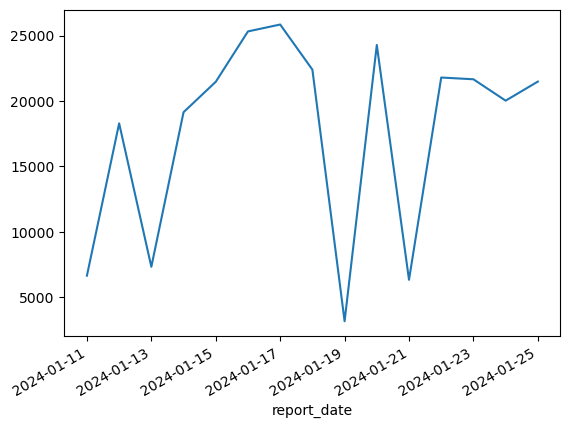

In [37]:
(
    df_train  # Выбираем DataFrame, над которым будем производить операции
    .group_by(pl.col("report_date").dt.round("1d"))  # Группируем данные по дате отчета с округлением до дня
    .agg(  # Применяем агрегацию к группам
        pl.col("query_id").n_unique().alias("n_queries"),  # Вычисляем количество уникальных query_id в каждой группе и задаем название новой колонке "n_queries"
    )
    .to_pandas()  # Преобразуем результаты в Pandas DataFrame для дальнейшей обработки и визуализации
    .set_index("report_date")  # Устанавливаем индекс DataFrame на основе столбца "report_date"
    ["n_queries"].plot()  # Строим график количества уникальных запросов по дням
)

In [38]:
# Фильтрация данных, оставляя только записи с report_date равным 2024-01-11 00:00:00
filtered_data = df_pandas[df_pandas['report_date'] == '2024-01-11 00:00:00']

# Подсчет количества уникальных значений столбца query_id
unique_query_count = filtered_data['query_id'].nunique()

# Вывод результата
print("Количество уникальных значений столбца query_id для 2024-01-11 00:00:00:", unique_query_count)


Количество уникальных значений столбца query_id для 2024-01-11 00:00:00: 6646


Графики количества уникальных запросов от даты и количества true от даты очень похожи, но значения разные. Предположу, что они сильно коррелируют между собой

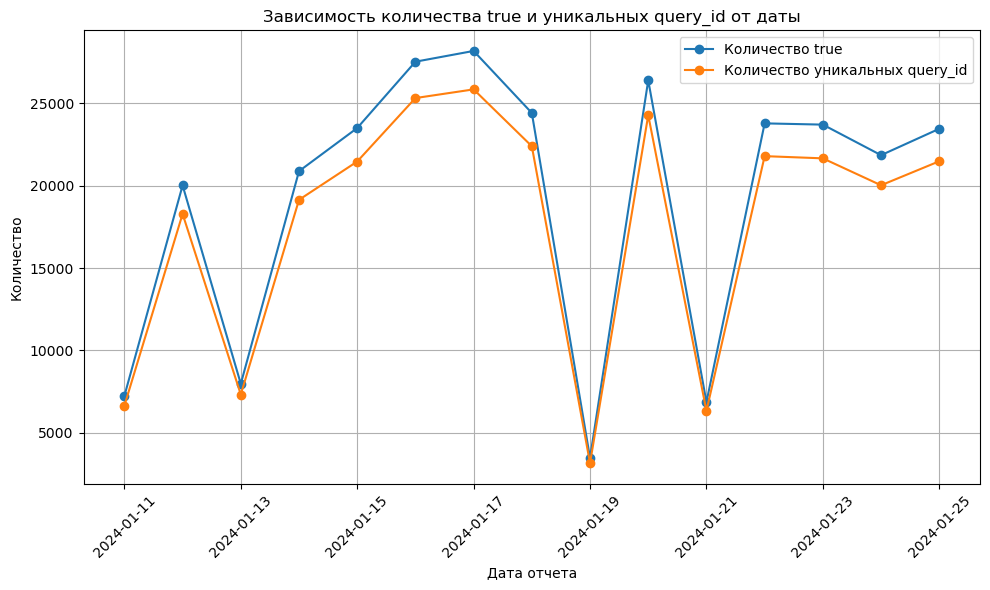

In [70]:
# Группировка данных по report_date и подсчет количества значений true и уникальных query_id
grouped_data = df_pandas.groupby('report_date').agg(
    true_count=pd.NamedAgg(column='target', aggfunc='sum'),
    unique_query_count=pd.NamedAgg(column='query_id', aggfunc='nunique')
)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(grouped_data.index, grouped_data['true_count'], label='Количество true', marker='o')
plt.plot(grouped_data.index, grouped_data['unique_query_count'], label='Количество уникальных query_id', marker='o')
plt.title('Зависимость количества true и уникальных query_id от даты')
plt.xlabel('Дата отчета')
plt.ylabel('Количество')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [71]:
grouped_data

,true_count,unique_query_count
report_date,,
2024-01-11,7242,6646
2024-01-12,20016,18286
2024-01-13,7974,7322
2024-01-14,20880,19141
2024-01-15,23498,21465
2024-01-16,27524,25317
2024-01-17,28177,25844
2024-01-18,24412,22394
2024-01-19,3473,3160


In [72]:
grouped_data.corr()

,true_count,unique_query_count
true_count,1.000000,0.999981
unique_query_count,0.999981,1.000000


Скореллированы близко к 1

## Зависимости связанные с rn

Теперь поисследуем колонку rn

Посмотрим на график значений rn от их количества

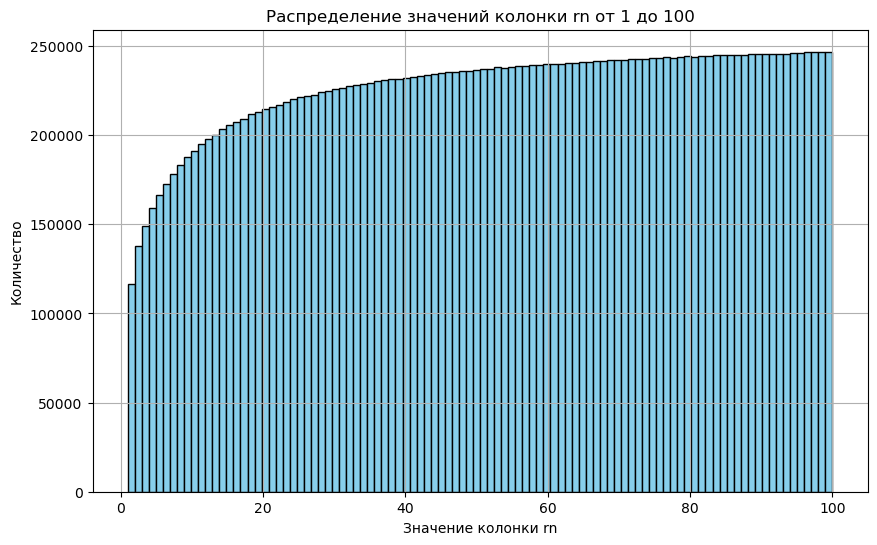

In [45]:
filtered_df = df_train.filter((df_train["rn"] >= 1) & (df_train["rn"] <= 100))

# Построим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(filtered_df["rn"], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение значений колонки rn от 1 до 100')
plt.xlabel('Значение колонки rn')
plt.ylabel('Количество')
plt.grid(True)
plt.show()


Значения равномерно увеличиватся, думаю это может быть связано с тем, что обычно первое что открывают, то и покупают. 

Посмотрим как вообще работает ранжирование сейчас. По идее, чем меньше rn тем больше должна быть доля покупок (доля true от суммы true false)

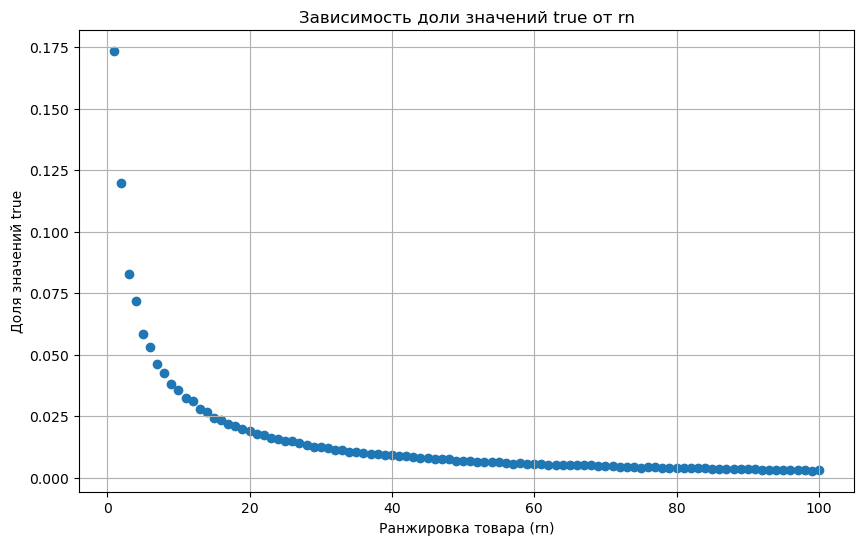

In [46]:
# Группировка данных по rn и подсчет доли значений true в target
mean_target_by_rn = df_train.group_by('rn').agg((pl.sum('target') / pl.count('target')).alias('mean_target'))

# Получение значений rn и средних значений target для построения графика
rn_values = mean_target_by_rn['rn'].to_numpy()
mean_target_values = mean_target_by_rn['mean_target'].to_numpy()

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(rn_values, mean_target_values, marker='o')
plt.title('Зависимость доли значений true от rn')
plt.xlabel('Ранжировка товара (rn)')
plt.ylabel('Доля значений true')
plt.grid(True)
plt.show()

Красивое, значит ранжирование уже работает хорошо

Нарисуем тоже самое, но с соединяющией кривой

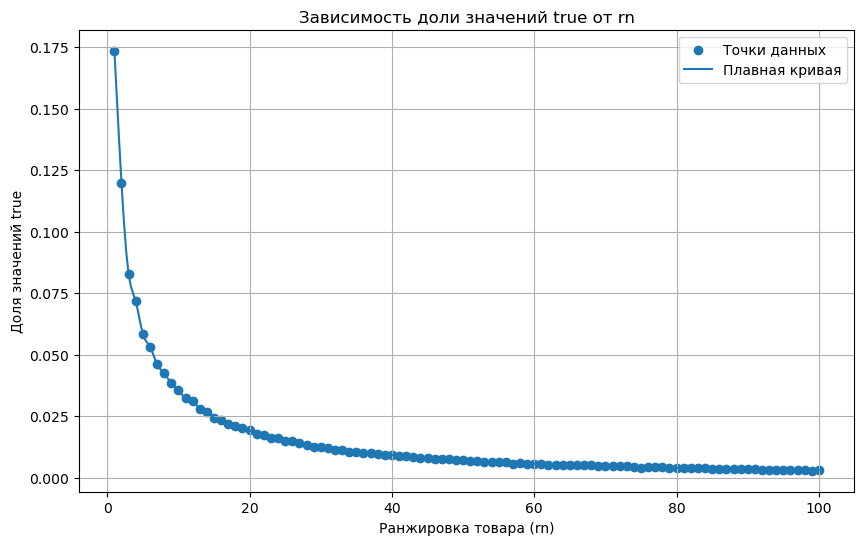

In [49]:
from scipy.interpolate import make_interp_spline
# Группировка данных по rn и подсчет доли значений true в target
mean_target_by_rn = df_train.group_by('rn').agg((pl.sum('target') / pl.count('target')).alias('mean_target'))

# Получение значений rn и средних значений target для построения графика
rn_values = mean_target_by_rn['rn'].to_numpy()
mean_target_values = mean_target_by_rn['mean_target'].to_numpy()

# Сортируем данные
sorted_indices = np.argsort(rn_values)
rn_values = rn_values[sorted_indices]
mean_target_values = mean_target_values[sorted_indices]

# Создаем плавную кривую через точки
spline = make_interp_spline(rn_values, mean_target_values)
rn_smooth = np.linspace(rn_values.min(), rn_values.max(), 300)
mean_target_smooth = spline(rn_smooth)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(rn_values, mean_target_values, marker='o', label='Точки данных')
plt.plot(rn_smooth, mean_target_smooth, '-', label='Плавная кривая')
plt.title('Зависимость доли значений true от rn')
plt.xlabel('Ранжировка товара (rn)')
plt.ylabel('Доля значений true')
plt.grid(True)
plt.legend()
plt.show()

Поскольку уже ранжирует хорошо, в дальнейшем буду учитывать это позиционное смещение

## Распределение данных

Посмотрим на распределения данных в фичах

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

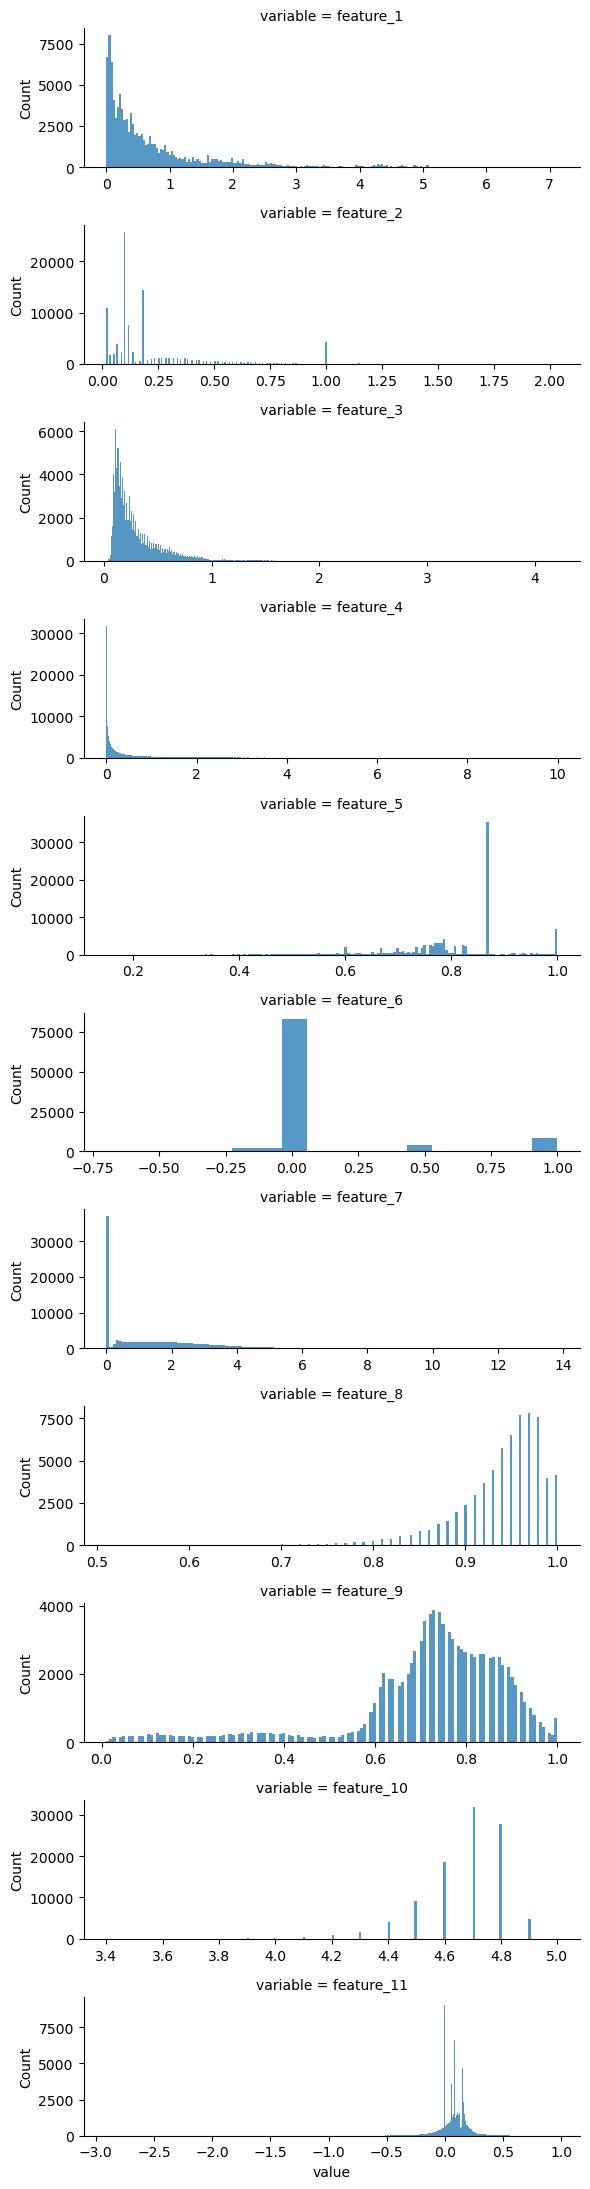

In [52]:
# Создаем гистограмму распределения данных
sns.displot(
    # Используем данные из датафрейма df_train
    data=(
        # Выбираем случайные 100 000 строк из df_train с фиксированным seed для воспроизводимости результатов
        df_train
        .sample(100_000, seed=42)
        # Исключаем столбцы "query_id", "report_date" и "target"
        .drop("query_id", "report_date", "target", "rn")
        # Преобразуем данные в pandas DataFrame и переводим их в "длинный" формат для построения гистограммы
        .to_pandas()
        .melt()
    ),
    # Указываем тип графика - гистограмма
    kind="hist",
    # Указываем переменную для создания ряда графиков
    row="variable",
    # Указываем переменную для оси X
    x="value",
    # Устанавливаем высоту ряда графиков
    height=2,
    # Устанавливаем соотношение сторон для графика
    aspect=3,
    # Указываем, что каждый график в ряду будет иметь свое собственное нормализованное распределение
    common_norm=False,
    # Указываем, что каждый график в ряду будет иметь свои собственные бины (интервалы) для гистограммы
    common_bins=False,
    # Передаем дополнительные параметры для фасетной сетки графиков
    facet_kws={"sharex": False, "sharey": False}
)

По фичам интересная 6, только 4 значенияи их довольно много . Остальные имеют логнормальное, биномиальные распределения. Можно будет в дальнейшем пологарифмировать.

Ящики с усами

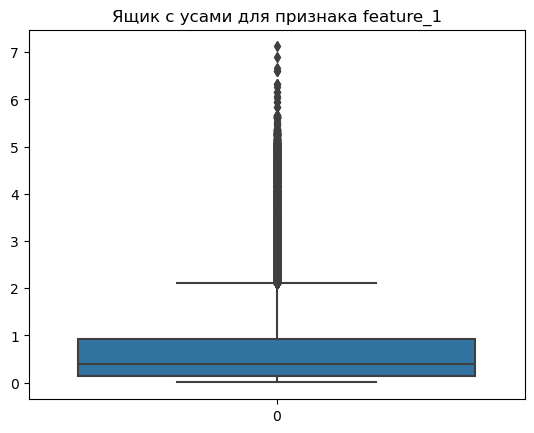

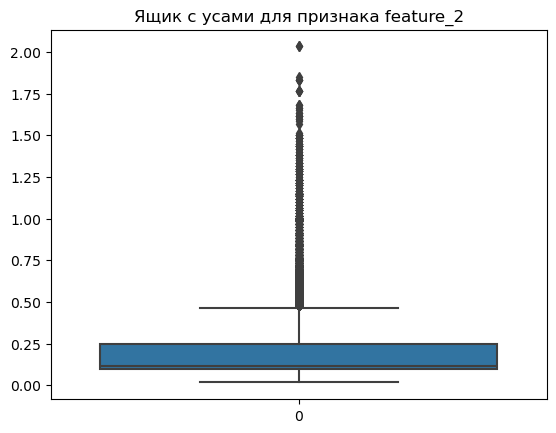

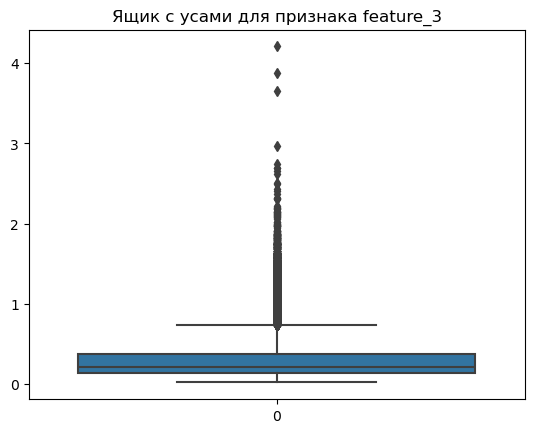

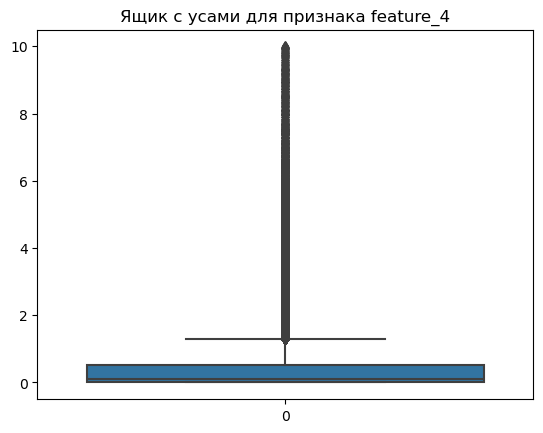

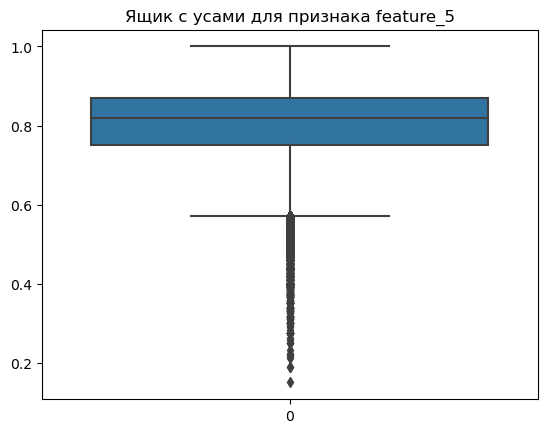

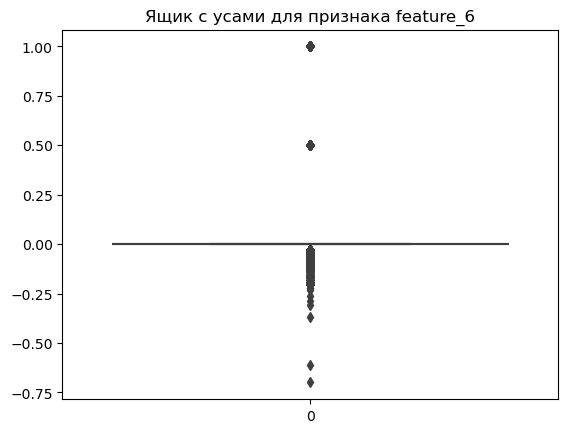

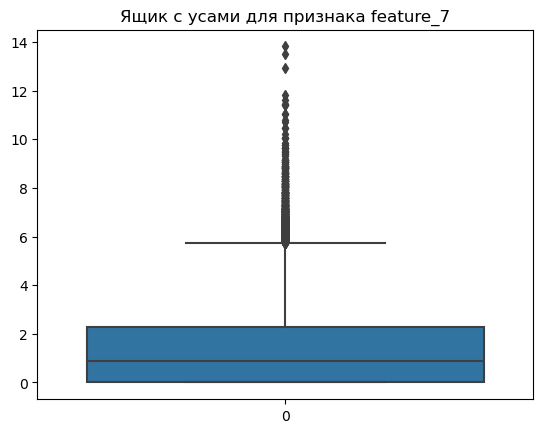

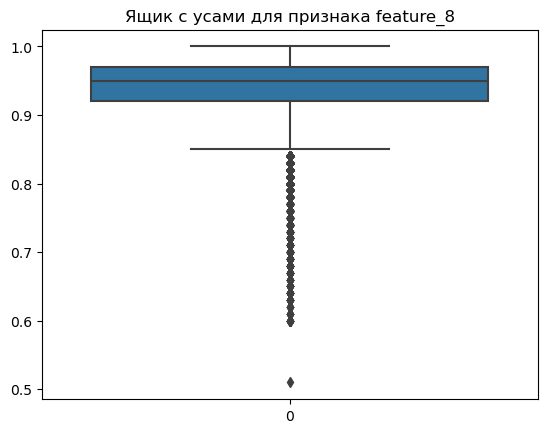

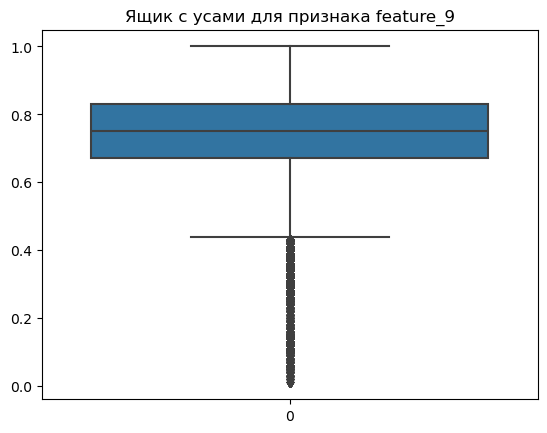

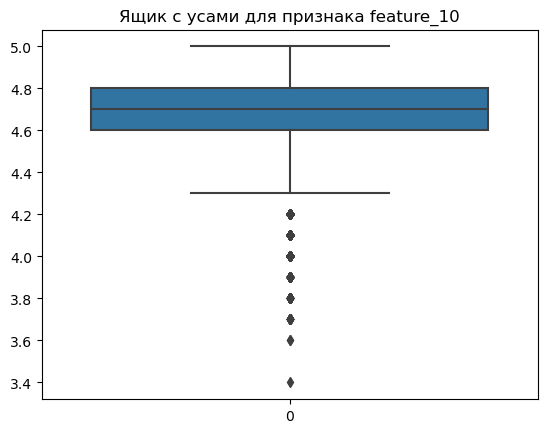

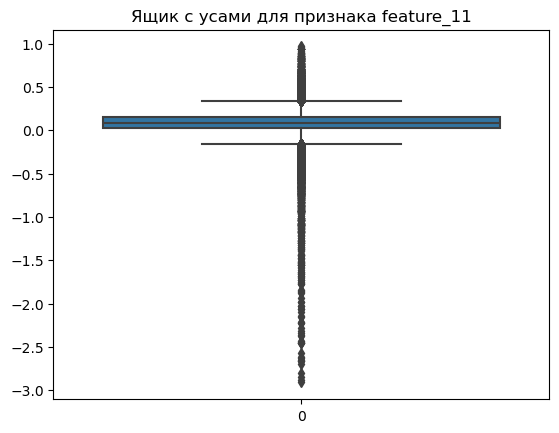

In [54]:
# Выбираем случайные 100 000 строк из df_train с фиксированным seed для воспроизводимости результатов
df_train_sampled = df_train.sample(100_000, seed=42)

# Исключаем столбцы "query_id", "report_date" и "target"
df_train_sampled = df_train_sampled.drop("query_id", "report_date", "target","rn")

# Получаем список названий столбцов (признаков)
features = df_train_sampled.columns

# Перебираем все признаки
for feature in features:
    # Создаем ящик с усами для текущего признака
    sns.boxplot(data=df_train_sampled.to_pandas()[feature], orient="v")
    plt.title(f'Ящик с усами для признака {feature}')
    plt.show()

Очень много выбросов, ящики с усами не особо информативные оказались

## Корреляции

<Axes: >

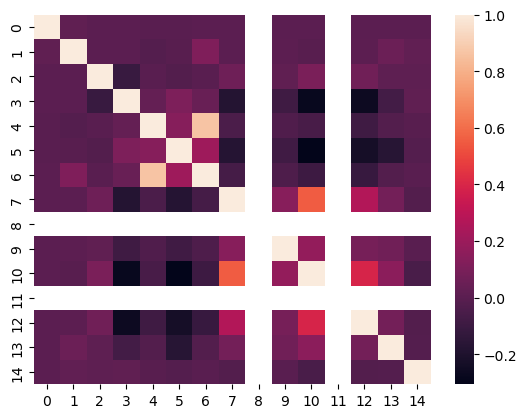

In [55]:
sns.heatmap(df_train.corr())

7 и 10 фичи скореллированы <br>
7 и 12 скореллированы  <br>
10 и 12 скореллированы<br>
6 и 4 скореллированы <br>

In [66]:
correlation_matrix = df_train[['feature_4', 'feature_7']].corr()
correlation_matrix

feature_4,feature_7
f64,f64
1.0,0.554043
0.554043,1.0


In [67]:
correlation_matrix = df_train[['feature_4', 'feature_9']].corr()
correlation_matrix

feature_4,feature_9
f64,f64
1.0,0.267011
0.267011,1.0


In [68]:
correlation_matrix = df_train[['feature_7', 'feature_9']].corr()
correlation_matrix

feature_7,feature_9
f64,f64
1.0,0.389737
0.389737,1.0


In [69]:
correlation_matrix = df_train[['feature_3', 'feature_1']].corr()
correlation_matrix

feature_3,feature_1
f64,f64
1.0,0.867274
0.867274,1.0


1 и 3 фичи скореллированы больше всего

## Сезонность

Ещё раз посмотрим на график зависимости количества уникальных запросов от даты, может увидим какую-то сезонность.

<Axes: xlabel='report_date'>

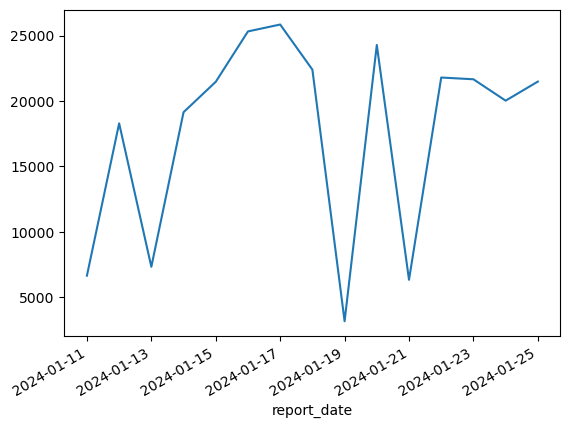

In [57]:
(
    df_train  # Выбираем DataFrame, над которым будем производить операции
    .group_by(pl.col("report_date").dt.round("1d"))  # Группируем данные по дате отчета с округлением до дня
    .agg(  # Применяем агрегацию к группам
        pl.col("query_id").n_unique().alias("n_queries"),  # Вычисляем количество уникальных query_id в каждой группе и задаем название новой колонке "n_queries"
    )
    .to_pandas()  # Преобразуем результаты в Pandas DataFrame для дальнейшей обработки и визуализации
    .set_index("report_date")  # Устанавливаем индекс DataFrame на основе столбца "report_date"
    ["n_queries"].plot()  # Строим график количества уникальных запросов по дням
)

Видим просадки 13 числа- суббота, 19 и 21 (пятница и воскресенье соотвественно)

<Axes: xlabel='report_date'>

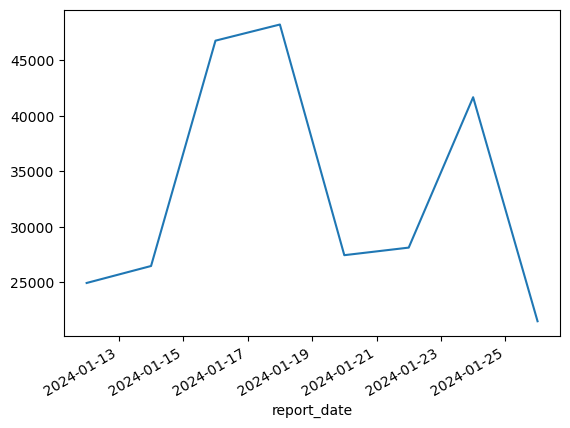

In [59]:
(
    df_train  # Выбираем DataFrame, над которым будем производить операции
    .group_by(pl.col("report_date").dt.round("2d"))  
    .agg(  # Применяем агрегацию к группам
        pl.col("query_id").n_unique().alias("n_queries"),  # Вычисляем количество уникальных query_id в каждой группе и задаем название новой колонке "n_queries"
    )
    .to_pandas()  # Преобразуем результаты в Pandas DataFrame для дальнейшей обработки и визуализации
    .set_index("report_date")  # Устанавливаем индекс DataFrame на основе столбца "report_date"
    ["n_queries"].plot()  # Строим график количества уникальных запросов по дням
)

При построении зависимости от 2х дней видно, что на выходных запросов меньше

Посмотрим на тестовой выборке

<Axes: xlabel='report_date'>

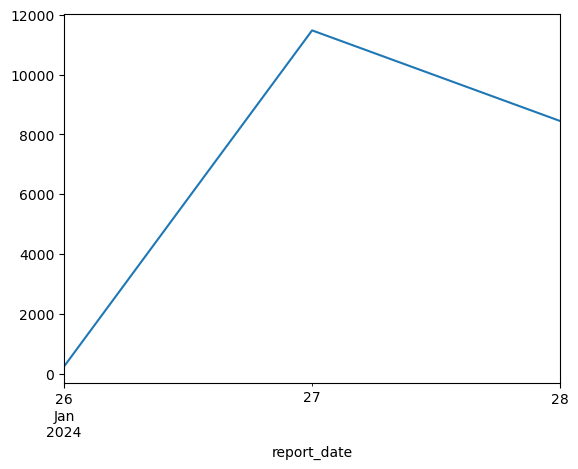

In [61]:
(
    df_test
    .group_by(pl.col("report_date").dt.round("1d"))
    .agg(
        pl.col("query_id").n_unique().alias("n_queries"),
    )
    .to_pandas()
    .set_index("report_date")
    ["n_queries"].plot()
)

Видим, что на тестовой выборке значения меньше, поскольку она взята на выходных

Сравним количество заказов на одном графике

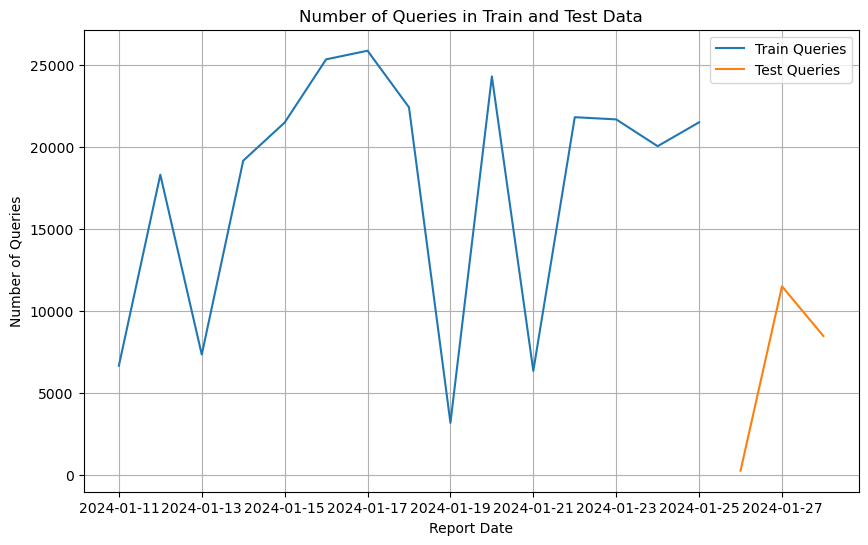

In [62]:
import matplotlib.pyplot as plt

# Вычисляем количество уникальных запросов в тренировочной выборке
train_counts = (
    df_train
    .group_by(pl.col("report_date").dt.round("1d"))
    .agg(pl.col("query_id").n_unique().alias("train_queries"))
    .to_pandas()
    .set_index("report_date")
)

# Вычисляем количество уникальных запросов в тестовой выборке
test_counts = (
    df_test
    .group_by(pl.col("report_date").dt.round("1d"))
    .agg(pl.col("query_id").n_unique().alias("test_queries"))
    .to_pandas()
    .set_index("report_date")
)

# Объединяем данные по дате
merged_counts = train_counts.merge(test_counts, how="outer", left_index=True, right_index=True)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(merged_counts.index, merged_counts["train_queries"], label="Train Queries")
plt.plot(merged_counts.index, merged_counts["test_queries"], label="Test Queries")
plt.xlabel("Report Date")
plt.ylabel("Number of Queries")
plt.title("Number of Queries in Train and Test Data")
plt.legend()
plt.grid(True)
plt.show()


Заметна очень большая разница в количестве заказов между трейновой и тестовой выборками

Пиковое время дня заказов на маркетплейсах — с 19:00 до 23:00 с понедельника по четверг.

Источник: https://secrets.tinkoff.ru/trendy/bolshe-vsego-prodazh/


# Выводы

В данных есть позиционное смещение связанное с rn.<br>
Есть сезонность. На выходных запросов меньше. <br>
Запросов в тестовой выборке сильно меньше. <br>
Количества уникальных запросов от даты и количество true в таргете от даты скоррелированы близко к 1 <br>
Из фичей больше всего скореллированы 1 и 3 <br>